In [ ]:
'''
Procedures
0. input xspec models data
1. trafo the data and pn rmf and arf to spo and res
2. enter the model: cie
3. use simulate command

* for simulate command
The user should start with a spectral model and a spectral data set (both matrix and spectrum). 
While xspec fakeit don't need a data.
'''

# 1. input xspec models data and trafo the data and pn rmf and arf to spo and res
just check trafo command, website is very clear

In [3]:
import os
import numpy as np
workdir = '/Users/eusracenorth/Documents/work/EXTG/ideal_mdls/'



# 1. compare mock spectra from ideal model in spex and xspec without absorption model

In [ ]:
# spex
# log exe compare_xspec_spex

# load data
data pn mock_spectrum_tot_ideal-mdl_nH_1e20_z_005_suzakunorm_15e-4_pn_A299_T_0.8_abun0.3_nH0.00
pl dev xs
pl type data
pl rx 0.3:2.0

# input model
com cie
com reds
com rel 1 2

# set parameter of cie
par 1 02:30 v 0.3
par 1 t v 0.8
par 1 norm v 2e7

# set distance
par 1 2 z v 0.05
dist 0.05 z

# show parameters
par show

# calculate model and plot
calc
pl

# 2. generate total spectrum from spex cie of different temperatures 
simulate noise f
simulate 1000000000

save in qdp files
https://spex-xray.github.io/spex-help/reference/plot/adum.html?highlight=save

In [6]:

T_arr = np.arange(0.1, 3.1, 0.1)

f = open(f'{workdir}/spex/mock_totspec_spex.com', 'w')

f.write('''
log output tot_spec.log

# load data
data pn mock_spectrum_tot_ideal-mdl_nH_1e20_z_005_suzakunorm_15e-4_pn_A299_T_0.8_abun0.3_nH0.00
pl dev xs
pl type data
pl rx 0.3:2.0

# input model
com cie
com reds
com rel 1 2

# set parameter of cie
par 1 02:30 v 0.3
par 1 t v 0.8
par 1 norm v 2e7

# set distance
par 1 2 z v 0.05
dist 0.05 z

''')

# change temperature -> calc -> plot -> save the output
for T in T_arr:
    f.write(f'''
par 1 t v {T}
par show

calc
pl

simulate noise f
simulate 1000000000

# save the output as qdp, where 1, -2 are the energies and the ctr
pl adum {T:.1f}
''')

f.write(f'log output close\n')

f.close()


# 3. read the qdp spectrums and make the plots

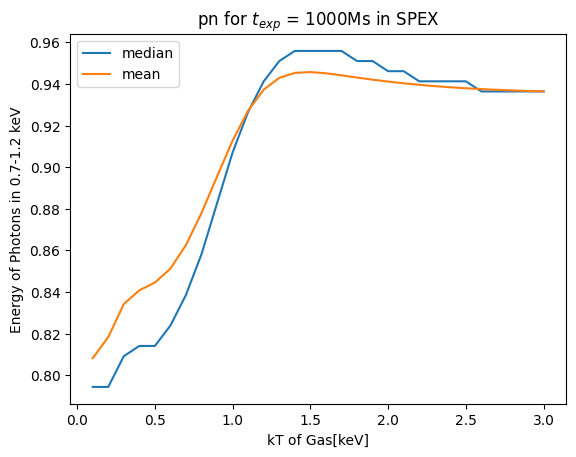

In [34]:
'''
1. load channel to energy in rmf file
2. load spectrum counts in 0.7-1.2 keV
3. cal median of the photons
'''


from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

os.chdir(f'{workdir}/spex/mock_totspectras')

T_arr = np.arange(0.1, 3.1, 0.1)
t_exp = 1000000


# initialize  
E_med_arr, E_mean_arr = np.zeros(T_arr.shape), np.zeros(T_arr.shape)

for i, T in enumerate(T_arr):
    # Read the data
    filename = glob(f'{T:.1f}.qdp')[0]
    df = pd.read_csv(filename,delim_whitespace=True, skiprows=[0], header=None)
    data = np.array(df[1:])
    E_bins = data[:,0].astype(float)
    E_msk = (E_bins<1.2) & (E_bins>0.7)
    ctr = data[:,6].astype(float)

    cts = np.array(ctr[E_msk] * t_exp).astype(int)
    data_arr = np.repeat(E_bins[E_msk], cts)

    E_mean_arr[i] = np.mean(data_arr)
    E_med_arr[i] = np.median(data_arr) # why median not sum or other summary statistics?

   
# make the plot
fig = plt.subplots()

plt.plot(T_arr, E_med_arr, label = 'median')
plt.plot(T_arr, E_mean_arr,   label = 'mean')

plt.title(f'pn for $t_{{exp}}$ = 1000Ms in SPEX')
plt.ylabel('Energy of Photons in 0.7-1.2 keV')
plt.xlabel('kT of Gas[keV]')
plt.legend()




In [25]:
del df